## 1. 基础配置

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import yaml
import os

In [216]:
# 设置显示选项以显示所有列
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', 1000)        # 设置显示宽度
pd.set_option('display.max_colwidth', None) # 显示完整的列内容

plt.rcParams['font.family'] = ['Microsoft YaHei', 'SimHei']  # 使用微软雅黑作为首选
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

def format_large_numbers(value, _):
    if value >= 100000:
        return f'{value/10000:.0f}万'
    else:
        return f'{value:.0f}'


In [217]:
# 读取配置文件
config = {}
with open('config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# 全局变量
dataset_dir = config['dataset_dir']
fig_dir = config['fig_dir']
keyword = config['keyword']


In [218]:
try:
    os.makedirs(fig_dir)
except:
    pass

## 2. 数据清洗与预处理

In [219]:
df = pd.read_csv(f'{dataset_dir}/{keyword}.csv')
print(df.shape)
print(df.describe(include='all'))

(153184, 64)
          type            id  author           mid         typeid typename                                      arcurl           aid          bvid                          title description                                                                      pic          play   video_review      favorites                   tag         review       pubdate      senddate duration badgepay hit_columns  view_type    is_pay  is_union_video  rec_tags new_rec_tags           like                                             upic  corner  cover  desc  url  rec_reason        danmaku  biz_data  is_charge_video        vt  enable_vt  vt_display  subtitle  episode_count_text  release_status  is_intervene      area     style  cate_name  is_live_room_inline  live_status  live_time    online     rank_index    rank_offset    roomid  short_id  spread_id  tags  uface       uid  uname  user_cover  parent_area_id  parent_area_name  watched_show
count   153184  1.531840e+05  153184  1.531840e+05 

很多列没有数据

In [220]:
# 删除无数据的列
df = df.dropna(axis=1, how='all')
print(df.isna().sum().sort_values(ascending=False).head())

description    31463
tag               30
title              1
id                 0
author             0
dtype: int64


In [221]:
# 处理空值
df['tag'] = df['tag'].fillna('')# 对于tag列，填充为空字符串
df = df.dropna(subset=['title'])# 对于title列，删除唯一一个空值行
df['description'] = df['description'].fillna('')# 对于description列，填充为空字符串
print("处理后空值统计:", df.isna().sum().sum(), '; 形状:', df.shape)# 确认处理结果

处理后空值统计: 0 ; 形状: (153183, 45)


In [222]:
print(df.head(1).T)

                                                                                              0
type                                                                                      video
id                                                                              115138275313258
author                                                                               观观Official
mid                                                                                   517437622
typeid                                                                                       65
typename                                                                                   网络游戏
arcurl                                          http://www.bilibili.com/video/av115138275313258
aid                                                                             115138275313258
bvid                                                                               BV1hzaMz6EE2
title                                   

In [223]:
# 保留这些列
columns_list = ['bvid','title','tag','description','arcurl','pic',# bv号 标题 标签 描述 链接 封面
                'pubdate','senddate','duration','hit_columns',# 发布时间 发送时间 时长 命中搜索的列
                'typename','typeid','author','mid','upic',# 分区类型 分区类型ID 作者 作者id 作者头像
                'is_pay','is_union_video','is_charge_video',# 是否付费 是否联合投稿 是否是充电视频
                'play','like','favorites','danmaku','review',# 播放数 点赞数 收藏数 弹幕数 评论数
                ]
df = df[columns_list]
print(df.shape)
print(df.describe(include='all'))

(153183, 23)
                bvid                          title                   tag description                                      arcurl                                                                      pic       pubdate      senddate duration hit_columns typename         typeid  author           mid                                             upic    is_pay  is_union_video  is_charge_video          play           like      favorites        danmaku         review
count         153183                         153183                153183      153183                                      153183                                                                   153183  1.531830e+05  1.531830e+05   153183      153183   153183  153183.000000  153183  1.531830e+05                                           153183  153183.0   153183.000000         153183.0  1.531830e+05  153183.000000  153183.000000  153183.000000  153183.000000
unique        135814                         129361        

处理异常数据

bv号有相同的

In [224]:
# 相同bvid只保留一个
df = df.drop_duplicates(subset=['bvid'], keep='first')
print(df.shape)
print(df['bvid'].describe())

(135814, 23)
count           135814
unique          135814
top       BV1t14y1W7Rg
freq                 1
Name: bvid, dtype: object


In [225]:
#删除title列的<em class="keyword">和</em>
df['title'] = df['title'].str.replace('<em class="keyword">', '').str.replace('</em>', '')

In [226]:
# 显示'hit_columns'列不同值的数量
print(df['hit_columns'].value_counts().sort_values(ascending=False))

hit_columns
['tag']                                      67928
['title', 'tag']                             51185
['title', 'description', 'tag']               5840
['description', 'tag']                        5297
['title']                                     1770
['description']                               1383
['author', 'tag']                              672
['title', 'author', 'tag']                     603
['author']                                     577
['title', 'description']                       300
['title', 'description', 'author', 'tag']      127
['title', 'author']                             84
['description', 'author', 'tag']                30
['title', 'description', 'author']              10
['description', 'author']                        7
[]                                               1
Name: count, dtype: int64


hit_columns中只有'author'的明显是无效数据

In [227]:
# 删除'hit_columns'列中数据为['author']的行
df = df[df['hit_columns'] != '[\'author\']']
print('\'hit_columns\'列为[\'author\']的形状：',df[df['hit_columns'] == '[\'author\']'].shape)
print(df.shape)

'hit_columns'列为['author']的形状： (0, 23)
(135237, 23)


In [228]:
# 1. 处理日期字段（将时间戳转换为可读日期）
df['pubdate_dt'] = pd.to_datetime(df['pubdate'], unit='s')
df['senddate_dt'] = pd.to_datetime(df['senddate'], unit='s')

# 2. 处理视频时长（将"0:51"格式转换为秒数）
def duration_to_seconds(duration_str):
    try:
        if ':' in duration_str:
            parts = duration_str.split(':')
            if len(parts) == 2:
                return int(parts[0]) * 60 + int(parts[1])
            elif len(parts) == 3:
                return int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
        return 0
    except:
        return 0

df['duration'] = df['duration'].apply(duration_to_seconds)    
    
# 3. 创建新特征 - 视频年龄（从发布到数据表中最晚的时间）
latest_date = df['pubdate_dt'].max()
df['video_age_days'] = (latest_date - df['pubdate_dt']).dt.days

print(df[['pubdate_dt', 'senddate_dt', 'duration','video_age_days']].head(3))
print(df[['pubdate_dt', 'senddate_dt', 'duration','video_age_days']].describe())

           pubdate_dt         senddate_dt  duration  video_age_days
0 2025-09-03 03:39:54 2025-09-03 03:39:54        43               0
1 2025-09-03 15:37:01 2025-09-03 15:37:01      1129               0
2 2025-09-03 14:32:02 2025-09-03 14:32:02       201               0
                          pubdate_dt                    senddate_dt      duration  video_age_days
count                         135237                         135237  1.352370e+05   135237.000000
mean   2024-06-01 10:21:08.929804800  2024-07-12 15:05:39.272943104  4.934371e+02      458.828797
min              2022-11-17 10:55:48            2022-11-18 05:05:56  2.000000e+00        0.000000
25%              2023-10-06 15:38:00            2023-11-17 02:54:32  4.000000e+01      248.000000
50%              2024-04-20 09:51:03            2024-07-06 11:24:32  8.000000e+01      501.000000
75%              2024-12-29 01:06:31            2025-03-22 05:27:55  1.880000e+02      698.000000
max              2025-09-03 15:59:11      

## 3. 探索性数据分析

### 3.1 命中分析

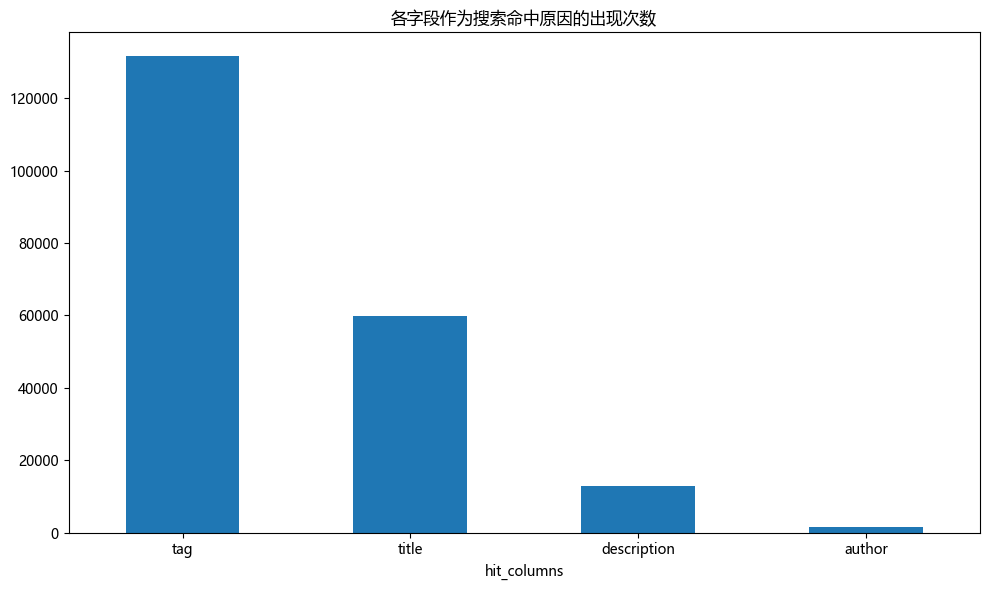

In [229]:
# 将 hit_columns 转换为列表
df['hit_columns'] = df['hit_columns'].apply(ast.literal_eval)

# 使用 explode 展开列表，然后统计每个字段的出现次数
hit_counts = df['hit_columns'].explode().value_counts()

# 创建柱状图
plt.figure(figsize=(10, 6))
hit_counts.plot(kind='bar')
plt.title('各字段作为搜索命中原因的出现次数')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}/各字段作为搜索命中原因的出现次数.png')
plt.show()

### 3.2 发布时间分析

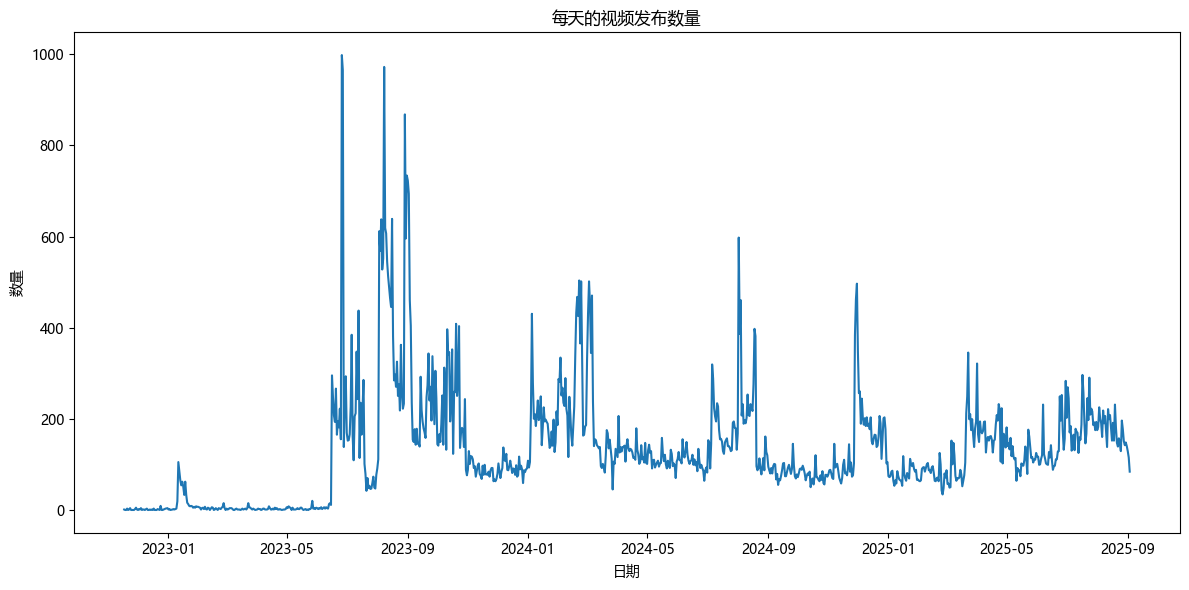

In [230]:
# 统计每天的发布数量，并绘制折线图
daily_counts = df['pubdate_dt'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line')
plt.title('每天的视频发布数量')
plt.xlabel('日期')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}/每天的视频发布数量.png')
plt.show()

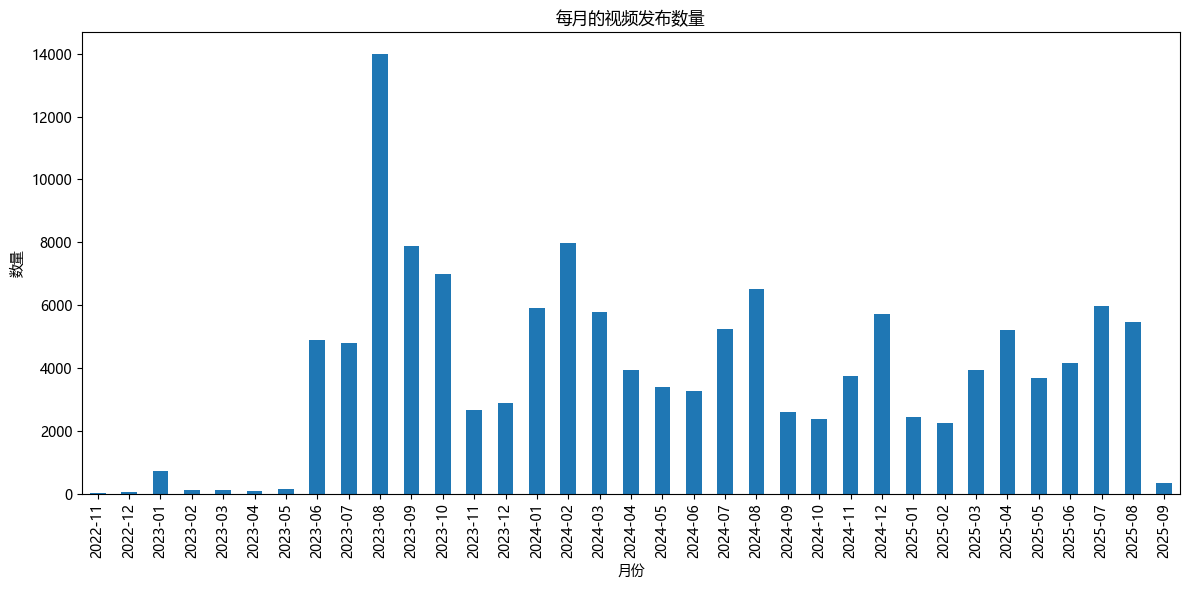

In [231]:
# 统计每月的发布数量，并绘制柱状图
monthly_counts = df['pubdate_dt'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar')
plt.title('每月的视频发布数量')
plt.xlabel('月份')
plt.ylabel('数量')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{fig_dir}/每月的视频发布数量.png')
plt.show()

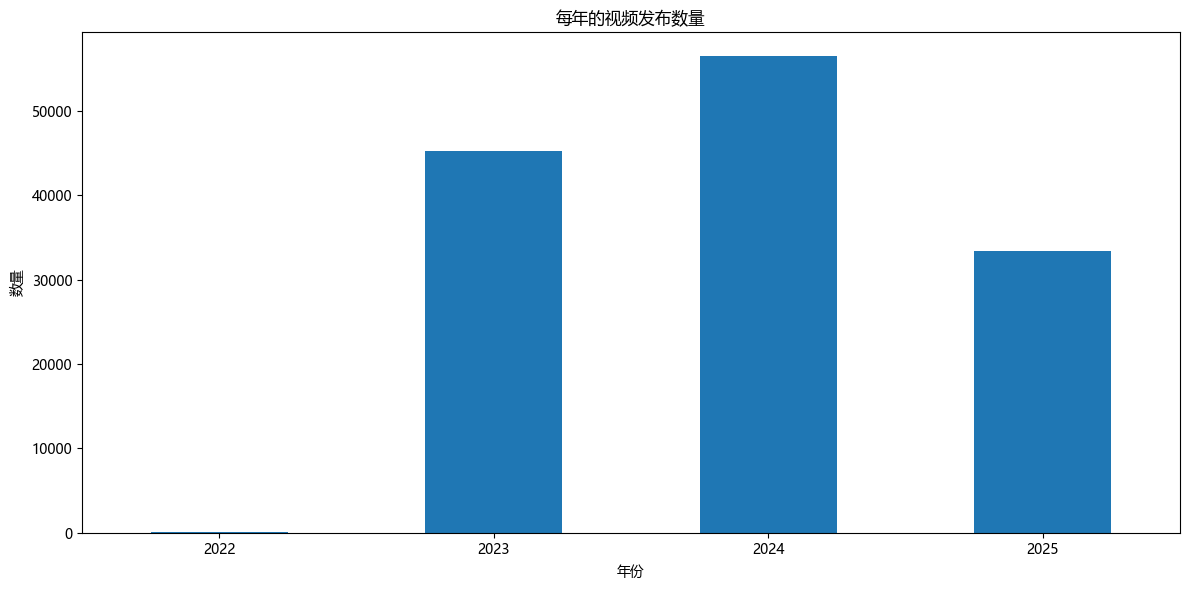

In [232]:
# 统计每年的发布数量，并绘制柱状图
yearly_counts = df['pubdate_dt'].dt.to_period('Y').value_counts().sort_index()

plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='bar')
plt.title('每年的视频发布数量')
plt.xlabel('年份')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}/每年的视频发布数量.png')
plt.show()

### 3.3 视频时长分析

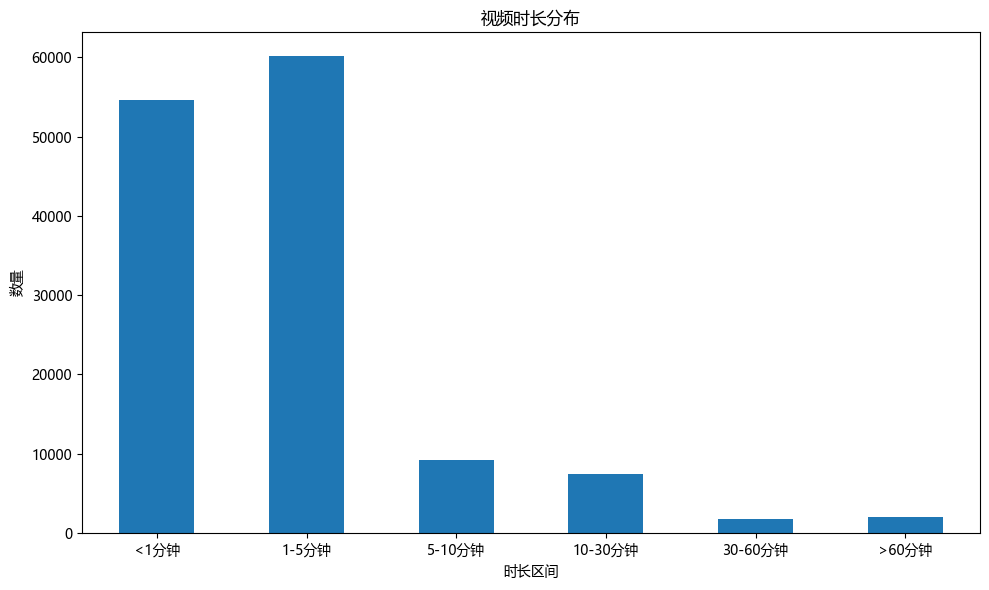

In [233]:
# 将视频时长分为几个区间
bins = [0, 60, 300, 600, 1800, 3600, float('inf')]
labels = ['<1分钟', '1-5分钟', '5-10分钟', '10-30分钟', '30-60分钟', '>60分钟']


# 统计每个区间的视频数量，并绘制柱状图
df['duration'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)
duration_counts = df['duration'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
duration_counts.plot(kind='bar')
plt.title('视频时长分布')
plt.xlabel('时长区间')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}/视频时长分布.png')
plt.show()

### 3.4 视频分析

In [255]:
def plt_video_top10(by:str, title:str):
    '''
    by:排序的值
    title:图表标题
    '''
    # 获取by量前十的视频
    top10 = df.sort_values(by=by, ascending=False).head(10)

    # 创建图表
    plt.figure(figsize=(12, 8))
    # 创建垂直柱状图
    bars = plt.bar(range(len(top10)), top10[by])
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_large_numbers))
    plt.title(title)
    plt.xticks(range(len(top10)), range(1, len(top10)+1))

    # 在图表下方添加详细信息
    table_data = []
    for i, (index, row) in enumerate(top10.iterrows(), 1):
        short_title = row['title'][:40] + '...' if len(row['title']) > 40 else row['title']
        table_data.append([i, row['bvid'], row['author'], short_title])

    # 创建表格
    table = plt.table(cellText=table_data,
                    colLabels=['排名', 'BV号', '作者', '标题'],
                    cellLoc='left',
                    loc='bottom',
                    bbox=[0, -0.5, 1, 0.4])

    table.auto_set_column_width([0, 1, 2, 3])  # 根据内容自动调整列宽
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/{title}.png')
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:31: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:32: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.savefig(f'{fig_dir}/{title}.png')
e:\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


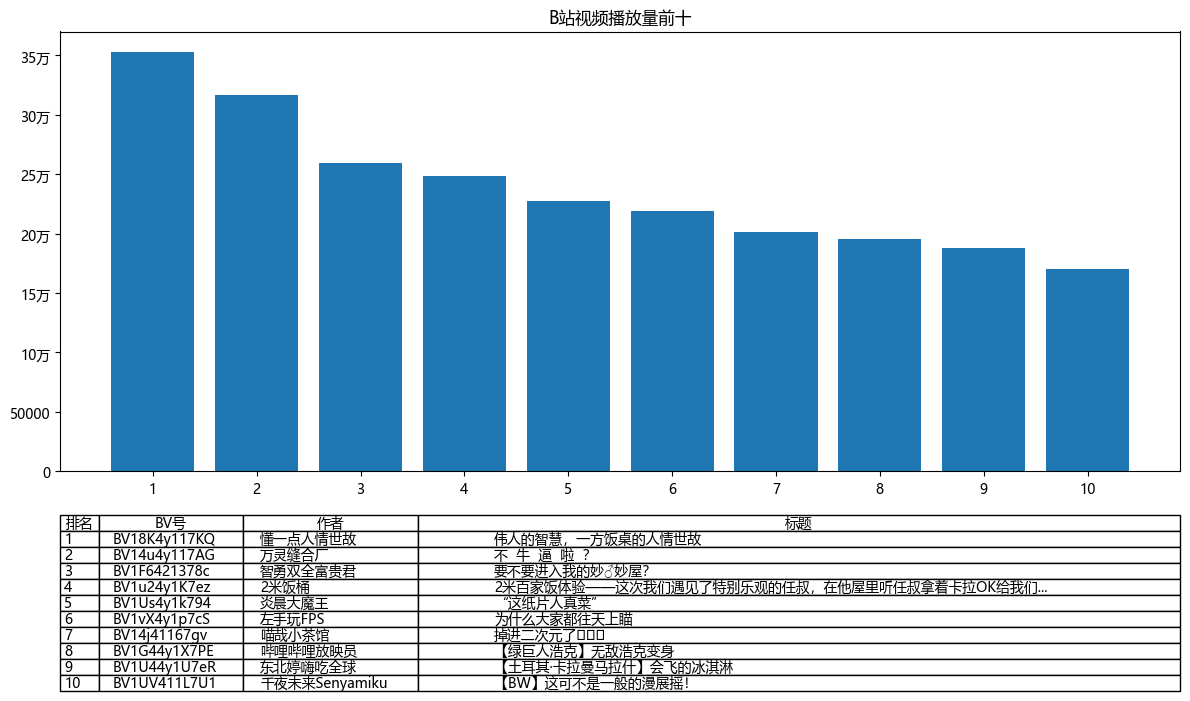

In [256]:
# 获取播放量前十的视频
plt_video_top10('like', 'B站视频播放量前十')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:31: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:32: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.savefig(f'{fig_dir}/{title}.png')
e:\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


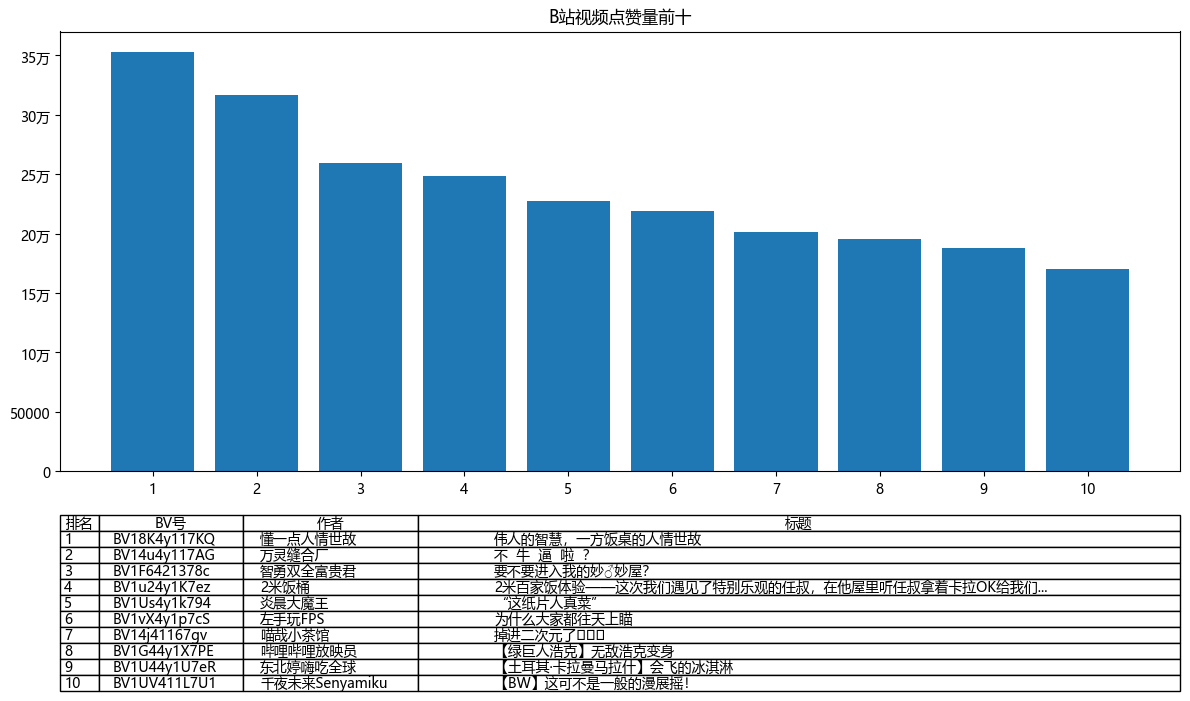

In [236]:
# 获取点赞量前十的视频
plt_video_top10('like', 'B站视频点赞量前十')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:31: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4844\652220424.py:32: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  plt.savefig(f'{fig_dir}/{title}.png')
e:\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128519 (\N{SMILING FACE WITH HALO}) missing from font(s) Microsoft YaHei, SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


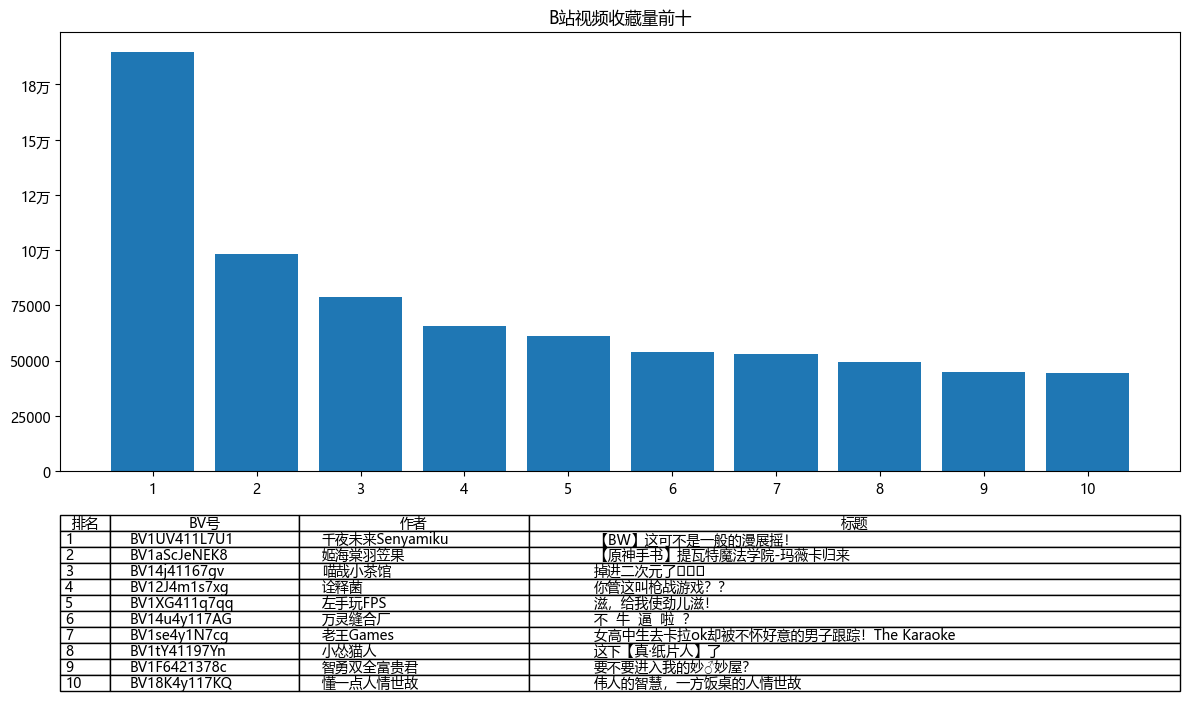

In [237]:
# 获取收藏量前十的视频
plt_video_top10('favorites', 'B站视频收藏量前十')

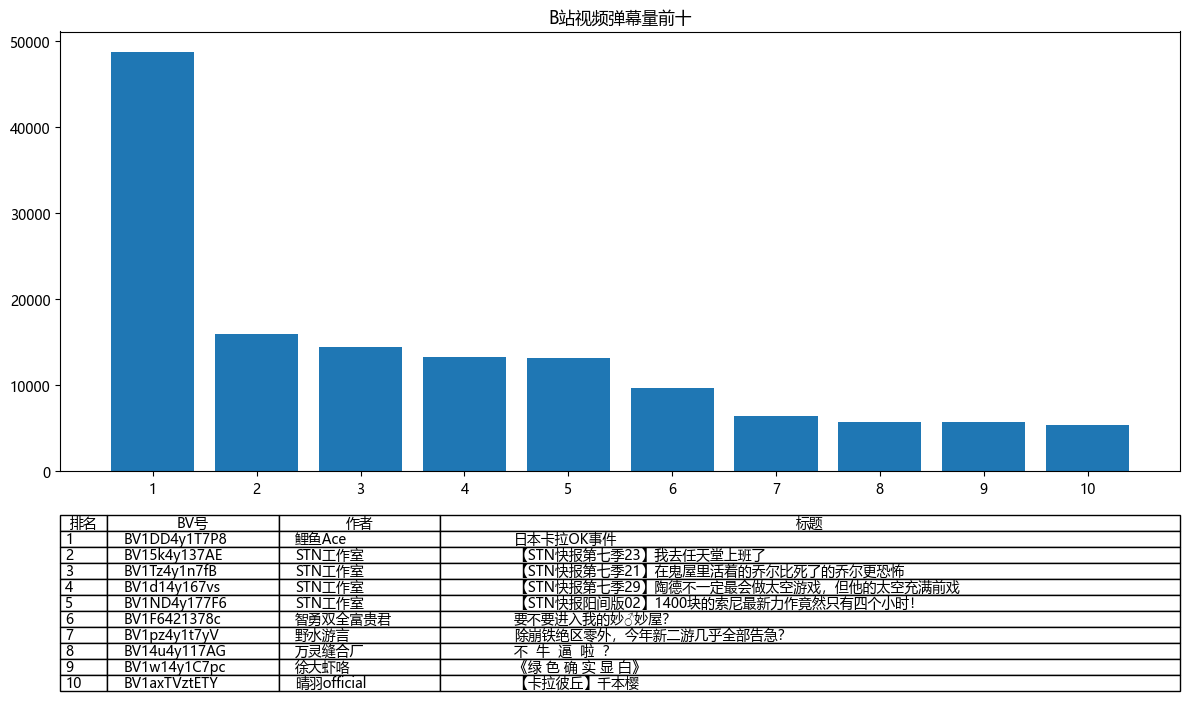

In [238]:
# 获取弹幕量前十的视频
plt_video_top10('danmaku', 'B站视频弹幕量前十')

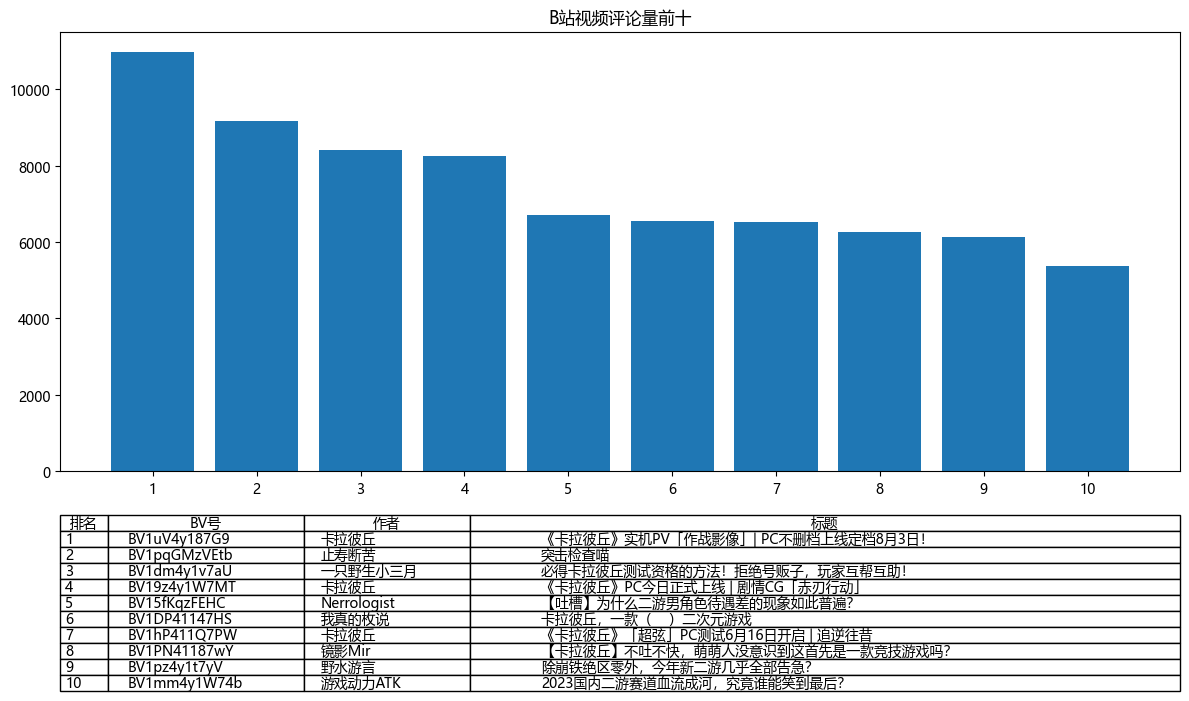

In [239]:
# 获取评论量前十的视频
plt_video_top10('review', 'B站视频评论量前十')

### 3.5 up主分析

In [267]:
#根据mid确定有多少up变成了'账号已注销'，在总up中的占比
up_counts = df['mid'].value_counts()
print('up主数量:', up_counts.shape[0])
outup_counts = df[df['author'] == '账号已注销']['mid'].value_counts()
print('注销up主数量:', outup_counts.shape[0])
print('注销up主占比:', outup_counts.shape[0] / up_counts.shape[0]*100,'%')

up主数量: 33046
注销up主数量: 2777
注销up主占比: 8.403437632391213 %


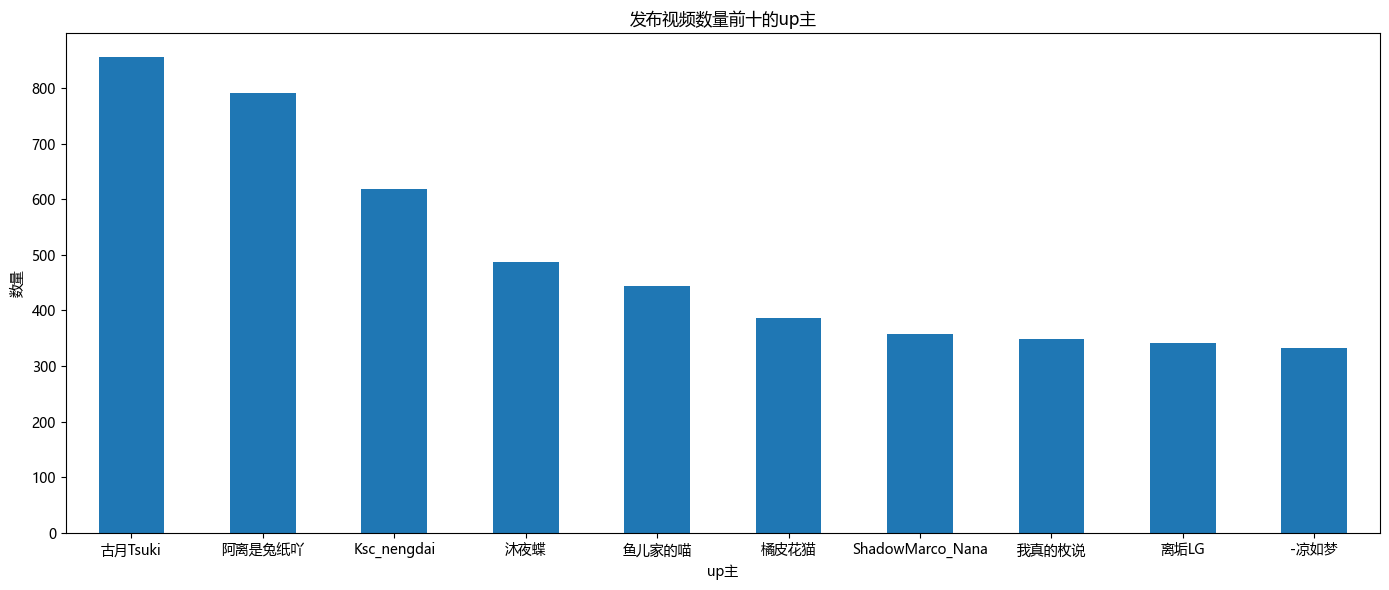

In [241]:
# 统计每个up主发布的视频数量，并绘制前十的柱状图（不包括'账号已注销')
up_pub_counts = df[df['author'] != '账号已注销']['author'].value_counts().head(10)

plt.figure(figsize=(14, 6))
up_pub_counts.plot(kind='bar')
plt.title('发布视频数量前十的up主')
plt.xlabel('up主')
plt.ylabel('数量')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{fig_dir}/发布视频数量前十的up主.png')
plt.show()

In [242]:
def plt_up_top10(by:str, title:str):
    '''
    by:排序的值
    title:图表标题
    '''
    up_play_counts = df[df['author'] != '账号已注销'].groupby('author')[by].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(14, 6))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_large_numbers))
    up_play_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('up主')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/{title}.png')
    plt.show()

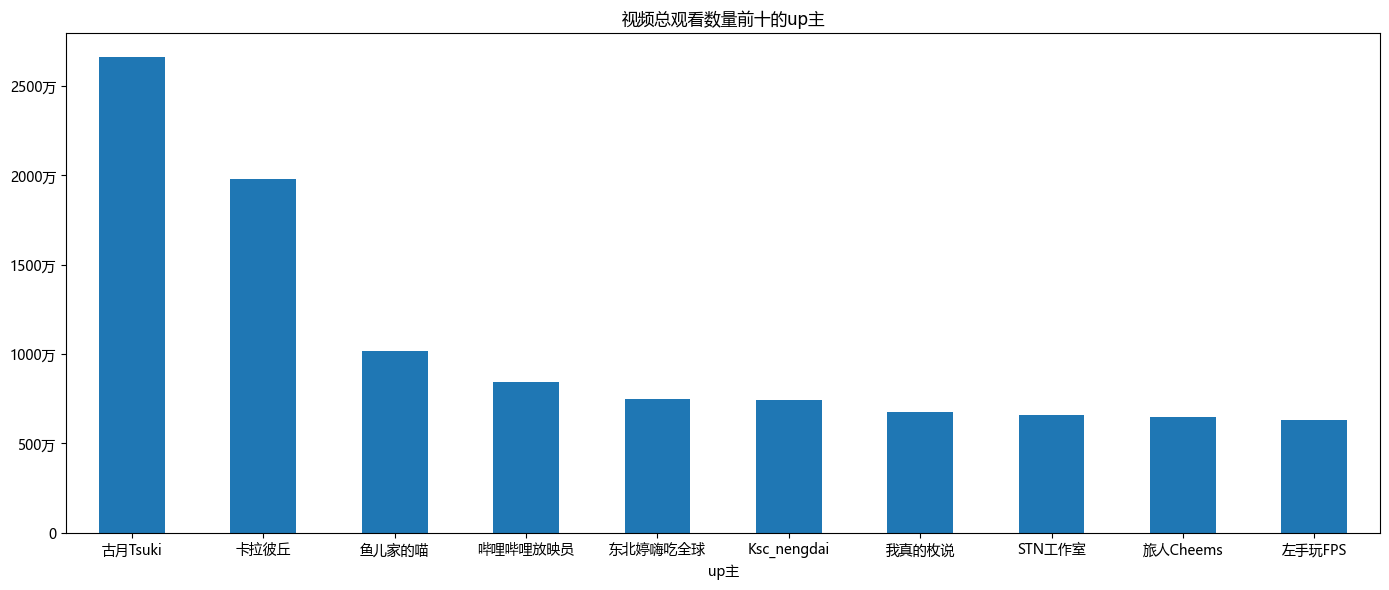

In [243]:
# 统计每个up主发布的视频总观看数量，并绘制前十的柱状图（不包括'账号已注销')
plt_up_top10('play', '视频总观看数量前十的up主')

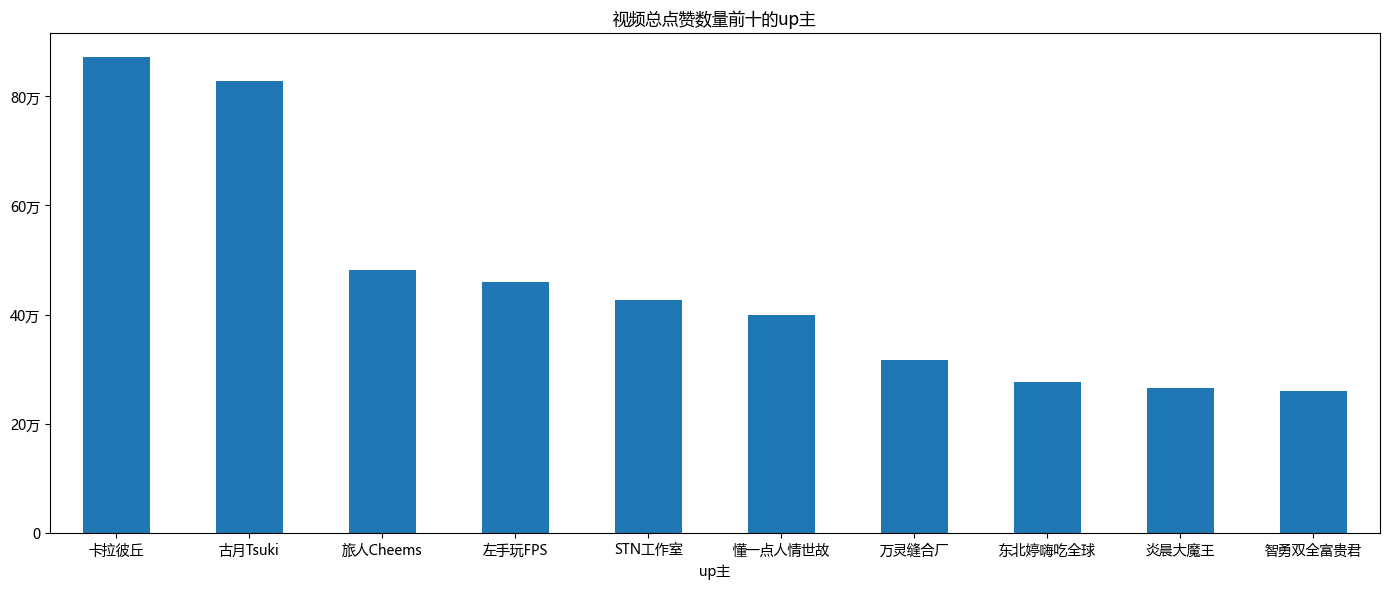

In [244]:
# 统计每个up主发布的视频总点赞数量，并绘制前十的柱状图（不包括'账号已注销')
plt_up_top10('like', '视频总点赞数量前十的up主')

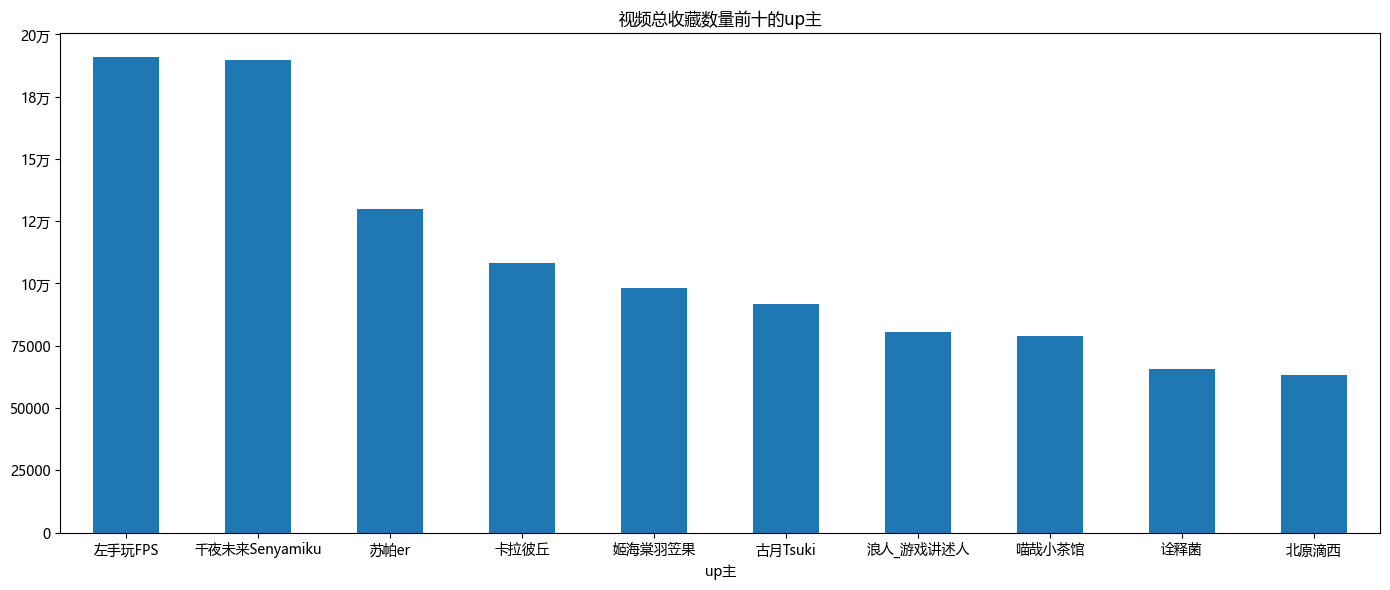

In [245]:
# 统计每个up主发布的视频总收藏数量，并绘制前十的柱状图（不包括'账号已注销')
plt_up_top10('favorites','视频总收藏数量前十的up主')

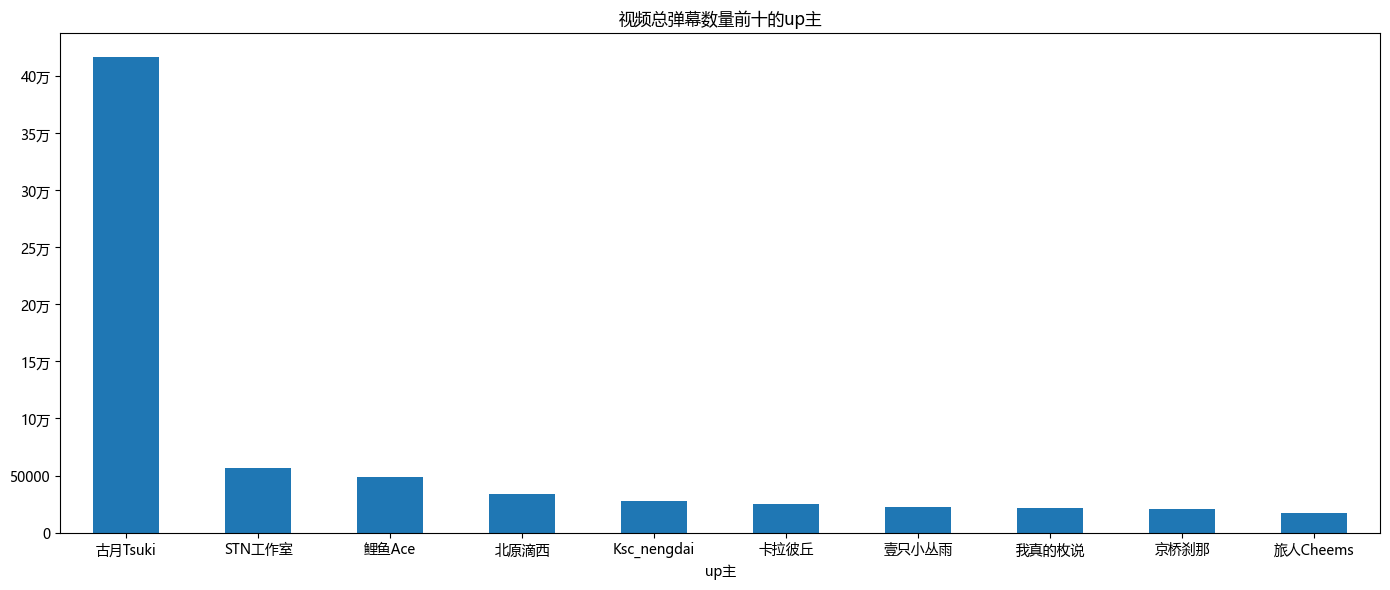

In [246]:
# 统计每个up主发布的视频总弹幕数量，并绘制前十的柱状图（不包括'账号已注销')
plt_up_top10('danmaku', '视频总弹幕数量前十的up主')

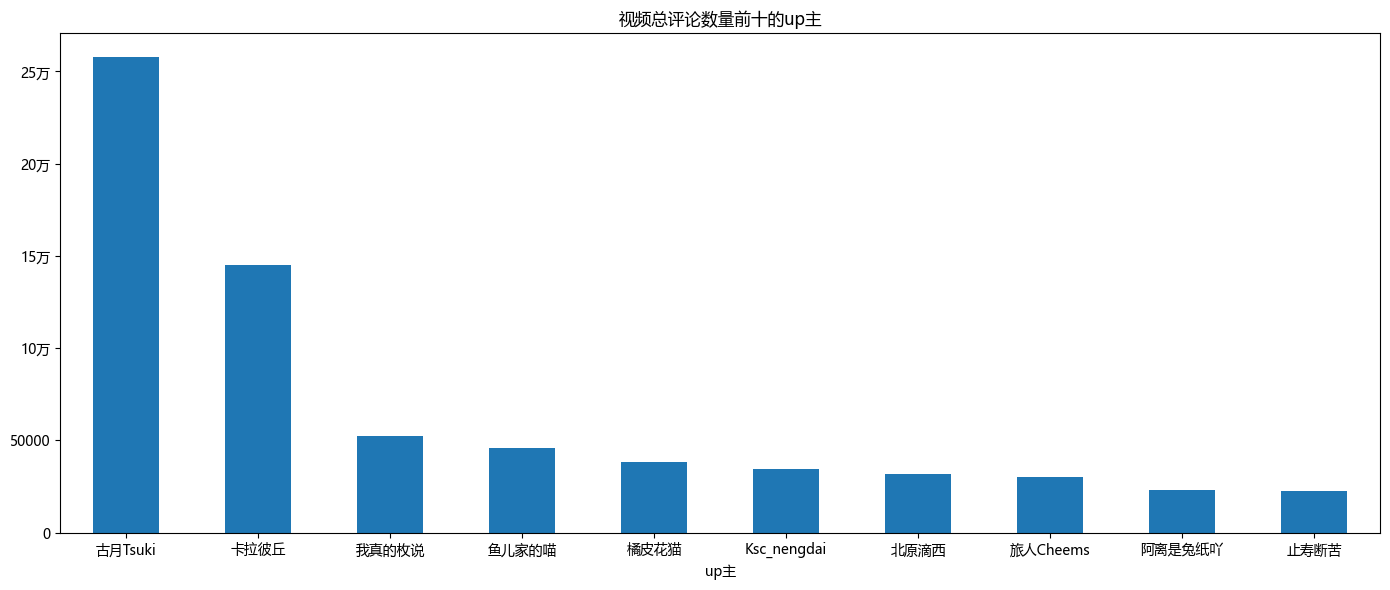

In [247]:
# 统计每个up主发布的视频总评论数量，并绘制前十的柱状图（不包括'账号已注销')
plt_up_top10('review', '视频总评论数量前十的up主')

古月狐狸怎么这么多喵 QWQ